# Lab Assignment 1: Data Cleaning


- This script need the cleaned version of _roads2 data and raw BMMS_overview data. 
- WBSIM_Lab1b also need to be inside the Jupyter Notebook file to have the shapefile from the (WBSIM_Lab1b\gis\gadm\BGD_adm0) the shapefile name is BGD_adm0
- timeit, shapefile and shapely library should also be installed in the Jupyter Notebook (use !pip install "name_of_library" to do so)

# 1. Fixing the roads

For fixing the road, rolling standard deviation and average were considered as a main method to detemine the outliers

### 1.1. Import the library and file path for each files needed

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import timeit
#import pylab 

#import re
#import seaborn as sns

import shapefile as shp
from shapely.geometry import Point, Polygon

# path of bridge data for reading csv file (_roads2)
path     = 'D:\Download\WBSIM_Lab1b\infrastructure\_roads2.csv'
# path of bridge data for writing csv file (_roads2)
savepath = 'D:\Jupyter_File\Advanced_Discrete_Cleaning\_roads2.csv'

# path of bridge data for reading Excel file (BMMS_overview)
bpath     = 'D:\Download\WBSIM_Lab1b\infrastructure\BMMS_overview.xlsx'
# path of bridge data for writing Excel file (BMMS_overview)
bsavepath = 'D:\Jupyter_File\Advanced_Discrete_Cleaning\BMMS_overview.xlsx'

# path of bangladesh region data for reading the shapefile (BGD_adm0)
shppath = 'D:\Jupyter_File\Advanced_Discrete_Cleaning\WBSIM_Lab1b\gis\gadm\BGD_adm0'

### 1.2. Importing the bridges, roads and shapefile data

In [2]:
# reading raw data
df_orig  = pd.read_csv(path,index_col=None, header=0)
bdf_orig = pd.read_excel(bpath, index_col=None, header=0)
sf_orig = shp.Reader(shppath)

# Remove duplicates 
#df = df_raw.drop_duplicates(subset=['lon','lat','chainage'], keep=False)

# copy dataframe
df = df_orig.copy()
bdf = bdf_orig.copy()
sf0 = sf_orig

# Display Number of data 
print('')
print('Total Road Data :' ,len(df),'Data')
print('')
print('Total Bridge Data :' ,len(bdf),'Data')


Total Road Data : 52210 Data

Total Bridge Data : 21407 Data


### 1.3. Convert Shapefile into List

In [3]:
# Function to get the shape file value from GIS
def convert_shp_to_list (sf,num_name):
    
    # Get description of the geofile name
    shps_name = sf.records()
    # Get all coordinates in the shapefile
    shps_coor = [s.points for s in sf.shapes()]
    
    # create a blank list and dictionary for operation 
    name_shape = []
    coor_shape_lat = []
    coor_shape_lon = []
    l = {}
    
    #define counter of the coordinate index
    counter = 0
    
    #Loop for extracting the name of the shape file
    for i in range(len(shps_name)):
        name_shape.append(shps_name[i][num_name])
        
    #Loop for extracting each coordinates of the Bangladesh shape file    
        for a in range(len(shps_coor[i])):
            l[counter] = {'Name':name_shape[i],'Longitude':shps_coor[i][a][0],'Latitude':shps_coor[i][a][1]}
            coor_shape_lat.append(shps_coor[i][a][1])
            coor_shape_lon.append(shps_coor[i][a][0])
            
            counter = counter+a
    
    return name_shape,shps_coor,coor_shape_lat,coor_shape_lon,l

#### Assigning shapefile into set of the list and visualize the Bangladesh boundaries

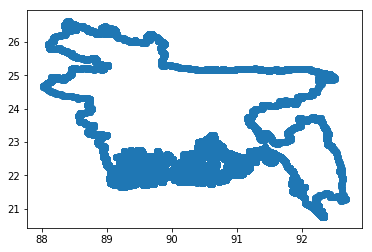

In [4]:
# assign the variables of the convert_shp_to_list function output
name_shp0, coor_shp0, coor_shp_lat0, coor_shp_lon0, l = convert_shp_to_list(sf0,2)

# plot example of the Bangladesh boundaries
for shape in sf0.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.scatter(x,y)
plt.show()

###  1.4. Define filtering function

In [5]:
# define filtering function
# 
# input:  dataframe of road, windowsize of mean/std, amount of std maximum allowed
# output: indices for lattitude errors and indices for longitude errors

def inspect(data, MeanWindow, StdWindow, threshold):
    
    # rolling standard deviation of lat and lon
    stdLat = data['lat'].rolling(window=StdWindow,min_periods=1,center=True).std()
    stdLon = data['lon'].rolling(window=StdWindow,min_periods=1,center=True).std()

    # moving average
    meanLat = data['lat'].rolling(window=MeanWindow,min_periods=1,center=True).mean()
    meanLon = data['lon'].rolling(window=MeanWindow,min_periods=1,center=True).mean()
    
    # determine errative values (Boolean)
    LatBool = abs(data['lat'] - meanLat) > threshold * stdLat
    LonBool = abs(data['lon'] - meanLon) > threshold * stdLon
    
    # determine index
    ErrorIndexLat = data[LatBool].index
    ErrorIndexLon = data[LonBool].index
    
    # return output
    return ErrorIndexLat, ErrorIndexLon, LatBool, LonBool

###  1.5. Order data by roads

In [6]:
# find road lenghts of individual roads
road_lengths = df['road'].value_counts().sort_index()
road_start = []
for i in range(len(df.road.unique())):
    
    road_start.append(sum(road_lengths[0:i]))
road_start.append(len(df))


### 1.6. Loop for detecting errative Lat and Lon values

In [7]:
# set filtering variables
WinMean   = 5   # size of moving average window
WinStd    = 30  # size of std window
threshold = 1.5   # maximum allowed strandard deviation difference
maxIter   = 10  # maximum amount of iteration steps allowed per road

# create empty lists
ErLat = []
ErLon = []

counter = 0
check   = 0
iterat  = []

# time calculation time
start = timeit.default_timer()

# loop for al N roads
for i in range(len(road_lengths)):
    
    counter = counter + 1
    # startpoint
    sp = road_start[i]
    ep = road_start[i+1]
    
    # selecting data
    roadFrame = df[sp:ep]
    
    # iteration counter
    iterat.append(check)
    
    # reset check value
    check = 0
    
    # continuously solving more points
    while (check < maxIter ): # maximum 4 iterations allowed

        ErrativeLat, ErrativeLon, LatBool, LonBool = inspect(roadFrame, WinMean, WinStd, threshold)
        
        # append to error list
        ErLat.append(ErrativeLat)
        ErLon.append(ErrativeLon)
        
        # determine if dataset is correct or not
        if len(ErrativeLat) + len(ErrativeLon) ==0 : # end while loop 
            check = 100
        else:
            
            # select new dataframe without errative values for next iteration
            roadFrame = roadFrame[~LatBool & ~LonBool]
            
            # set check counter
            check = check + 1
    
stop = timeit.default_timer()

print('time elapsed for error detection: ', stop-start)
print('roads checked: ', counter)


time elapsed for error detection:  3.632130474769758
roads checked:  877


### 1.7. Replace errative values with interpolation

In [8]:
# create complete list with errors
ErLonList = [y for x in ErLon for y in x]
ErLatList = [y for x in ErLat for y in x]
print('amount of errative longitude values found: ', len(ErLonList))
print('amount of errative lattitude values found: ', len(ErLatList))

amount of errative longitude values found:  215
amount of errative lattitude values found:  279


### 1.8. Interpolate the Latitude and Longitude outliers and mark them into another column

In [9]:
# Creating a new column in the dataframe
df['Outliers'] = False

# Marking the ouliers row data by filling data for 'Outliers' column into True
df.loc[ErLonList,'Outliers'] = True
df.loc[ErLatList,'Outliers'] = True

# Change the outliers in lattitude and longitude values into NaN values for interpolation later on
df.loc[ErLonList,'lon'] = np.nan
df.loc[ErLatList,'lat'] = np.nan

# interpolation for lattitude and longitude column with nearest neighboorhood method
df['lon'] = df['lon'].interpolate(method='nearest')
df['lat'] = df['lat'].interpolate(method='nearest')

### 1.9. Save data back to csv

In [10]:
# save the file to a csv
# - do not save index column (index=False)
# - create ""markings around every data (quoting=1)

df.to_csv(savepath, index=False, quoting=1)

# 2. Fixing the Bridges

Fixing the bridges started with changing the swapped longitude and lattitude, matching the coordinates from the clean version of the roads, and checking each coordinates points within the boundaries of the Bangladesh or not

### 2.1 Fixing Swapped Lattitude and Longitude data

In [11]:
# Count how many swapped values data 
print("Swapped Coordinates identified",len(bdf[ (bdf['lat'] > 80)]))

Swapped Coordinates identified 15


In [12]:
# Swap the bridge coordinate
swapped_bridge_index  = (bdf[(bdf['lat'] > 80)]).index

bdf['empty_data'] = 0

bdf.loc[swapped_bridge_index,'empty_data'] = (bdf[ (bdf['lat'] > 80)]['lon'])
bdf.loc[swapped_bridge_index,'lon'] = (bdf[ (bdf['lat'] > 80)]['lat'])
bdf.loc[swapped_bridge_index,'lat'] = (bdf[ (bdf['lat'] > 80)]['empty_data'])

# Count how many swapped values data 
len(bdf[ (bdf['lat'] > 80)])
print("Swapped Coordinates identified",len(bdf[ (bdf['lat'] > 80)]))

Swapped Coordinates identified 0


### 2.2 Matching the Coordinates in the Bridge data with the Roads data

In [13]:
def bridge_and_roads_compared (bdf,df):
    count = 0
    notfound = []

    # loop over all bridges
    for i in range(len(bdf)):
    
        j = i
    
        # try catch loop
        try:

            # pick bridge data
            bridge = bdf.loc[j,:]


            # find corresponding lat and lon from road data
            road = df[(df['road'] == bridge.road) & (df['lrp'] == bridge.LRPName)]

            # if reaction is empty trim last letter from LRPName and match again
            if (road.empty):
                road = df[(df['road'] == bridge.road) & (df['lrp'].str.match(bridge.LRPName[0:len(bridge.LRPName)-1],case=True))]

            # if there are multiple reactions pick only first
            if len(road) > 1:
                road = road.iloc[0]


            # for nonempty road data check lat and lon differences
            if  not road.empty:

                # find differences in Lat and Lon
                LatDif = abs(bridge.lat - road.lat)
                LonDif = abs(bridge.lon - road.lon)

                # change datatype of LatDif or LonDif if necessary
                if isinstance(LatDif, pd.core.series.Series):
                    LatDif = LatDif.values
                    LonDif = LonDif.values

                # find if differences are larger than accepted
                if (LatDif > 0.1) or (LonDif > 0.1):

                    count = count + 1

                    # change type of variable
                    if isinstance(road, pd.core.series.Series):
                        lat = road['lat']
                        lon = road['lon']
                    else:
                        lat = road.iloc[0,:].lat
                        lon = road.iloc[0,:].lon

                    # replace lat and lon
                    bdf.loc[i,'lat'] = lat
                    bdf.loc[i,'lon'] = lon

            else:
                notfound.append(j)
        except:
            notfound.append(j)
    
    return count,notfound


In [14]:
# start timer
start = timeit.default_timer()

# matching bridges based on roads function
count,notfound = bridge_and_roads_compared(bdf,df)

# stop timer
stop = timeit.default_timer()

# display the summary of the process
print('total wrong values found: ',count)
print('total bridges that were not connected with road data: ', len(notfound))
print('total time for loop calculation: ', stop-start)

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in greater


total wrong values found:  434
total bridges that were not connected with road data:  1091
total time for loop calculation:  525.3347234249666


### 2.3 Checking points outside the boundaries of Bangladesh

Two alternative algorithm were developed for checking the points, these were:
1. Compare each data coordinates (points) according to the Polygon shape file of Bangladesh

2. Since the first algorithm takes more or less one hour to run, the second method used  bounding box function (bbox) in the shapefile to check whether each points in lattitude or longitude outside the bounding box of Bangladesh

#### Polygon Check (Do this if we have high specs computer!!! need at least 1 hour run time, uncomment each line to use this) 

In [15]:
## define empty list that will contain all of error indexes
#index_error = []
#coords = coor_shp0[0]
#poly = Polygon(coords)

## time calculation time
#start = timeit.default_timer()

#for i in range(len(bdf)):
#    # Create Point objects
#    point_check = Point(bdf['lon'][i], bdf['lat'][i])
    
#    if not(point_check.within(poly)):
#        index_error.append(i)

#stop = timeit.default_timer()
#
#print('Out-of-Bounds Identified:', len(index_error))
#print('time elapsed for error detection: ', stop-start)

In [16]:
## Mark the outliers row
#bdf.loc[index_error,'Outliers'] = True
## Change the error latitude and longitude values into NaN
#bdf.loc[index_error,'lat'] = np.nan
#bdf.loc[index_error,'lon'] = np.nan

#### Boundary box check

In [17]:
# Set the range for Longitude boundary box
maxlong = sf0.bbox[2]
minlong = sf0.bbox[0]
# Set the range for Latitude boundary box
maxlat = sf0.bbox[3]
minlat = sf0.bbox[1]

# Get the indexes of out of bounds latitude and longitude
error_lat = bdf[(bdf['lat'] < minlat) | (bdf['lat'] > maxlat)].index
error_lon = bdf[(bdf['lon'] < minlong) | (bdf['lon'] > maxlong)].index

# Mark the outliers row
bdf.loc[error_lat,'Outliers'] = True
bdf.loc[error_lon,'Outliers'] = True

# Change the error latitude and longitude values into NaN
bdf.loc[error_lat,'lat'] = np.nan
bdf.loc[error_lon,'lon'] = np.nan

### 2.4 Interpolate the NaN values

In [18]:
bdf['lon'] = bdf['lon'].interpolate(method='nearest')
bdf['lat'] = bdf['lat'].interpolate(method='nearest')

### 2.5 Run matching bridge with roads one more time to make sure the interpolated bridges values on the roads

In [19]:
# start timer
start = timeit.default_timer()

# matching bridges based on roads function
count,notfound = bridge_and_roads_compared(bdf,df)

# stop timer
stop = timeit.default_timer()

# display the summary of the process
print('total wrong values found: ',count)
print('total bridges that were not connected with road data: ', len(notfound))
print('total time for loop calculation: ', stop-start)

total wrong values found:  2
total bridges that were not connected with road data:  1091
total time for loop calculation:  482.34728323735965


### 2.6 Saving bridge data

In [20]:
writer = pd.ExcelWriter(bsavepath, engine='xlsxwriter')

#Convert the dataframe to an XlsxWriter Excel object.
bdf.to_excel(writer, sheet_name='BMMS_overview', index=False)

#Close the Pandas Excel writer and output the Excel file.
writer.save()